In [1]:
# Import libraries
# TODO: Clean this again, to only contain libraries for this part
import pandas as pd
import gc
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
#import torchaudio
from torchvision import transforms
import librosa
import librosa.display
from datasets import Dataset
from collections import Counter
from pathlib import Path
#import torchaudio
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

In [2]:
# Modified version from the class in HA1.
class InstrumentsData(Dataset):
    def __init__(self, root, transform, guitar_label=0, piano_label=1, drum_label=2, bird_label = 3):
        # Check if root parameter is valid.
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
         
        # Set class variables
        self.root = root
        self.transform = transform
        self._guitar_label = guitar_label
        self._piano_label = piano_label
        self._drum_label = drum_label
        self._bird_label = bird_label
        
        # Collect samples of guitar, piano and drum and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
        
    def __len__(self):
        return len(self._samples)
        
    def __getitem__(self, index):
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
        
    def _collect_samples(self):
        # Iterator over guitar filepath
        guitar_paths = self._collect_imgs_sub_dir(self.root / "Mel_guitar")
        # Iterator of pairs (path, gutiar_label)
        # Uses the map function to create an iterator.
        guitar_paths_and_labels = map(lambda path: (path, self._guitar_label), guitar_paths)
        
        # Same for piano and drums
        piano_paths = self._collect_imgs_sub_dir(self.root / "Mel_piano")
        piano_paths_and_labels = map(lambda path: (path, self._piano_label), piano_paths)
        
        drum_paths = self._collect_imgs_sub_dir(self.root / "Mel_drum")
        drum_paths_and_labels = map(lambda path: (path, self._drum_label), drum_paths)
        
        bird_paths = self._collect_imgs_sub_dir(self.root / "birds")
        bird_paths_and_labels = map(lambda path: (path, self._bird_label), bird_paths)

        return sorted(list(chain(guitar_paths_and_labels, piano_paths_and_labels, 
                                 drum_paths_and_labels, bird_paths_and_labels)), 
                      key=lambda x: x[0].stem)
        
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        # Checks if sub-directory exists and returns (jpg-) content if it does.
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")

In [3]:
# Simple transform that resizes the images.
# TODO: Add random flips to help with overfitting?
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(p=0.5), 
                                transforms.RandomVerticalFlip(p=0.5), 
                                transforms.ToTensor()]) # ToTensor also normalizes.

In [5]:
# Create train and validation DataLoaders.
train_dataloader = DataLoader(InstrumentsData("trainFFT512", transform), batch_size = 33, shuffle=True)
val_dataloader = DataLoader(InstrumentsData("valFFT512", transform), batch_size = 33, shuffle=True)

In [6]:
# The CNN network (base from Sara's HA1).
class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super(FirstCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 20, 3),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(20, 10, 3),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(10, 10, 3),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            # Make conv layer input into one dim.
            nn.Flatten(),
            # Infers input size.
            nn.LazyLinear(20),
            nn.Dropout(0.2),
            nn.LazyLinear(4),
            nn.LogSoftmax(dim=1)
        )
        '''
        self.first_conv_layer = nn.Conv2d(in_channels=3, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.second_conv_layer = nn.Conv2d(in_channels=10, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.third_conv_layer = nn.Conv2d(in_channels=10, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.fully_connected_layer = nn.Linear(
            in_features=(img_size-6)*(img_size-6)*10,
            out_features=3
        )'''
    
    def forward(self, input_batch):
        out = self.features(input_batch)
        out = self.classifier(out)
        return out.squeeze()
        
        '''
        out = self.first_conv_layer(input_batch)
        out = self.second_conv_layer(out)
        out = self.third_conv_layer(out)
        np_flat = out.reshape(input_batch.size(0) ,(out.size(dim=1)*out.size(dim=2)*out.size(dim=3)))
        z = self.fully_connected_layer(np_flat)
        return torch.softmax(z, dim=1).squeeze() '''

In [7]:
# Borrowed from HA1
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [8]:
# Chose the node with the highest percentage as the label.
def output_to_label(z):   
    c = []
    for preds in z:
        pred = torch.argmax(preds)       
        c.append(pred.float())
    #device = "cuda"
    return torch.tensor(c)#.to(device)

In [9]:
# Create loss function, initialize network and optimizer.
loss_fn = nn.NLLLoss()
network = FirstCnn(32)
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)

# Train the network.
model, train_losses, train_accs, val_losses, val_accs = training_loop(network, optim, loss_fn, train_dataloader, val_dataloader, 10, 10)

C:\Users\Sara\anaconda3\envs\dml\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Starting training
	Batch 10/62: 	Train loss: 1.320, 	Train acc.: 0.415, 	Val. loss: 1.373, 	Val. acc.: 0.240
	Batch 20/62: 	Train loss: 1.179, 	Train acc.: 0.491, 	Val. loss: 1.352, 	Val. acc.: 0.279
	Batch 30/62: 	Train loss: 1.067, 	Train acc.: 0.609, 	Val. loss: 1.294, 	Val. acc.: 0.440
	Batch 40/62: 	Train loss: 1.002, 	Train acc.: 0.606, 	Val. loss: 1.165, 	Val. acc.: 0.668
	Batch 50/62: 	Train loss: 0.890, 	Train acc.: 0.748, 	Val. loss: 1.017, 	Val. acc.: 0.707
	Batch 60/62: 	Train loss: 0.809, 	Train acc.: 0.785, 	Val. loss: 0.862, 	Val. acc.: 0.760
Epoch 1/10: Train loss: 1.034, Train acc.: 0.612, Val. loss: 0.821, Val. acc.: 0.770
	Batch 10/62: 	Train loss: 0.690, 	Train acc.: 0.767, 	Val. loss: 0.793, 	Val. acc.: 0.757
	Batch 20/62: 	Train loss: 0.697, 	Train acc.: 0.788, 	Val. loss: 0.711, 	Val. acc.: 0.791
	Batch 30/62: 	Train loss: 0.594, 	Train acc.: 0.821, 	Val. loss: 0.533, 	Val. acc.: 0.856
	Batch 40/62: 	Train loss: 0.551, 	Train acc.: 0.833, 	Val. loss: 0.525, 	Val.

In [10]:
def plotting(loss_train, loss_val, acc_train, acc_val, batch_value, poly_grade, moving_avg_steps):

    # Create plot
    fig, (ax, ax2) = plt.subplots(1,2)

    # Not a value for val at the same rate as train, so this is to make them fit in the same plot.
    val_x_range = [x*batch_value + batch_value for x in range(len(loss_val))]

    # Scatter plot losses for val and train
    ax.scatter(range(len(loss_train)), loss_train)
    ax.scatter(val_x_range, loss_val, color='lime')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Value')

    # Approximate a polynomial of poly_grade to the training losses to see the trend
    fit_train_losses = np.polyfit(range(len(loss_train)), loss_train, poly_grade)
    train_loss_poly = np.poly1d(fit_train_losses)

    ax.plot(range(len(loss_train)),train_loss_poly(range(len(loss_train))), color='r')
    ax.legend(['Train loss', 'Val loss', 'Train loss polynomial'])

    # Start plotting accuracies
    ax2.scatter(range(len(acc_train)), acc_train)
    ax2.scatter(val_x_range, acc_val, color='lime')
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('Percentage')

    # Calcualte moving average for visualizing the trend

    avg = moving_avg(moving_avg_steps, acc_train)
    ax2.plot(range(len(acc_train)), avg, color='r')
    ax2.legend(['Train acc', 'Val acc', 'Train acc moving average'])

    fig.set_figwidth(12)
    fig.show()

def moving_avg(window, values):
    average_y = []
    for i in range(len(values) - window + 1):
        average_y.append(np.mean(values[i:i+window]))

    for i in range(window - 1):
         average_y.insert(0, np.nan)

    return average_y

C:\Users\Sara\AppData\Local\Temp\ipykernel_556\2532450580.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


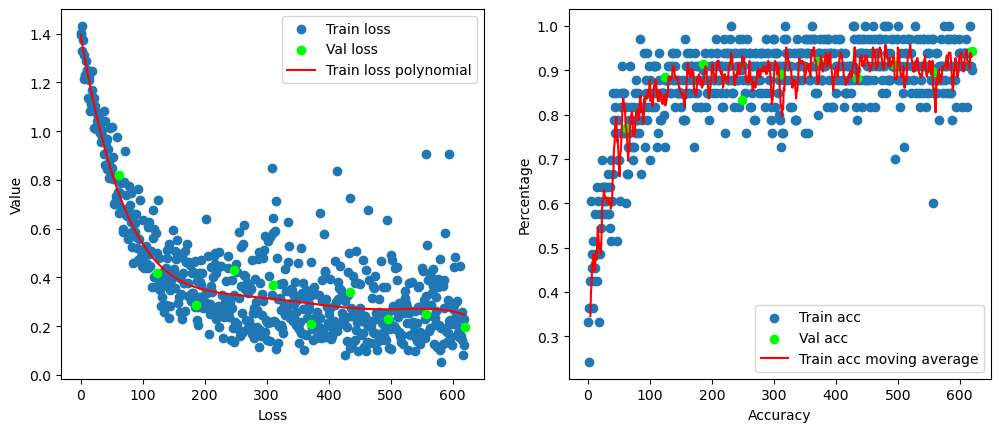

In [11]:
# Plot the results from the above training.
plotting(train_losses, val_losses, train_accs, val_accs, 62, 5, 5) 

In [12]:
# Make test data of type DataLoader
test_dataloader = DataLoader(InstrumentsData("testFFT512", transform), batch_size = 32, shuffle=True)

# From HA1.
accuracy = 0.0
correct_values = 0
y_predictions = []
y_correct = []
# Perform test with no adagrad
with torch.no_grad():
    for batch_x_value, batch_y_value in test_dataloader:
        prediction = network(batch_x_value)
        loss = loss_fn(prediction, batch_y_value)
    
        hard_preds = prediction.argmax(dim=1)
        y_predictions.extend(hard_preds)
        y_correct.extend(batch_y_value)
        
        correct_values += (hard_preds == batch_y_value).sum().item()
        
        accuracy = correct_values/len(InstrumentsData("test", transform))    
    
    print('Test acc: {:.2f} '.format(accuracy))

Test acc: 0.81 


<Axes: >

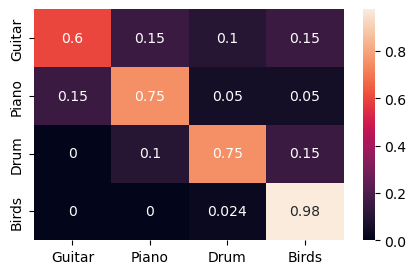

In [13]:
# From (Sara's) IHA2
from sklearn.metrics import confusion_matrix
import seaborn as sn
confmat = confusion_matrix(y_correct, y_predictions)
names = ['Guitar', 'Piano', 'Drum', 'Birds']
df_cm = pd.DataFrame(confmat / np.sum(confmat, axis=1)[:, None], index = [i for i in names],
                     columns = [i for i in names])

# Plot matrix and add colours
plt.figure(figsize=(5,3))
sn.heatmap(df_cm, annot=True)